## Compare LightGBM in the case of binary class (Sell, Buy)

In [1]:
import sys
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)
import lightgbm as lgb
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from utility_functions import (
    backtest_strategy,
    display_report,
    plot_feature_imp,
    plot_strategy,
    select_threshold,
    tune_params,
)

warnings.filterwarnings("ignore")

In [2]:
METRIC = "average_precision"
TEST_SIZE = 200
TIMEOUT = 600

In [3]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [4]:
target = pd.read_csv("../data/processed/target_df.csv", parse_dates=True, index_col=0)[
    "target"
]

In [5]:
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [6]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [7]:
interest_rate = wk_df["r"].values

## Control LightGBM Classifier without new data

In [8]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

### Split dataset

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df,
    target.values.flatten(),
    test_size=TEST_SIZE,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [10]:
params = tune_params(X_train, y_train, METRIC, TIMEOUT, max_iter=35, max_dep=12)

[I 2024-02-18 23:47:22,431] A new study created in memory with name: no-name-f3cd3931-4563-4c5d-8944-27c9f2aaa0c2
[I 2024-02-18 23:47:22,831] Trial 0 finished with value: 0.5174810054479516 and parameters: {'n_estimators': 20, 'lambda_l1': 0.0026568795174116543, 'lambda_l2': 5.691357779832114, 'num_leaves': 51, 'min_sum_hessian_in_leaf': 3.06251108704905, 'feature_fraction': 0.700901728913941, 'feature_fraction_bynode': 0.40951542213203884, 'bagging_fraction': 0.4510358790928265, 'bagging_freq': 6, 'min_child_samples': 80, 'num_grad_quant_bins': 6, 'max_depth': 6, 'extra_trees': True}. Best is trial 0 with value: 0.5174810054479516.
[I 2024-02-18 23:47:23,276] Trial 1 finished with value: 0.3005859607406655 and parameters: {'n_estimators': 20, 'lambda_l1': 0.001149913335423407, 'lambda_l2': 17.663118301499786, 'num_leaves': 33, 'min_sum_hessian_in_leaf': 6.191357356715355, 'feature_fraction': 0.688325844495046, 'feature_fraction_bynode': 0.39313322880424395, 'bagging_fraction': 0.43045

Number of finished trials: 150
Best trial:
  Number: 75
  Value: 0.6866003192817628
  Params: 
    n_estimators: 30
    lambda_l1: 7.093648730971469e-07
    lambda_l2: 0.007206491482230547
    num_leaves: 44
    min_sum_hessian_in_leaf: 0.035004442984233206
    feature_fraction: 0.3561878958059562
    feature_fraction_bynode: 0.8729857386968961
    bagging_fraction: 0.8719226653454326
    bagging_freq: 4
    min_child_samples: 5
    num_grad_quant_bins: 11
    max_depth: 11
    extra_trees: False


In [11]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "clf",
            lgb.LGBMClassifier(
                **params
                | {
                    "random_state": 1968,
                    "objective": "binary",
                    "metric": METRIC,
                    "verbosity": -1,
                    "boosting_type": "gbdt",
                }
            ),
        ),
    ]
)

In [12]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('clf',
                 LGBMClassifier(bagging_fraction=0.8719226653454326,
                                bagging_freq=4, extra_trees=False,
                                feature_fraction=0.3561878958059562,
                                feature_fraction_bynode=0.8729857386968961,
                                lambda_l1=7.093648730971469e-07,
                                lambda_l2=0.007206491482230547, max_depth=11,
                                metric='average_precision', min_child_samples=5,
                                min_sum_hessian_in_leaf=0.035004442984233206,
                                n_estimators=30, num_grad_quant_bins=11,
                                num_leaves=44, objective='binary',
                                random_state=1968, verbosity=-1))])

In [13]:
# In-sample score
pipe.score(X_train, y_train)

0.9128440366972477

In [14]:
in_sample_preds = pipe.predict(X_train)

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       680
           1       0.91      0.91      0.91       628

    accuracy                           0.91      1308
   macro avg       0.91      0.91      0.91      1308
weighted avg       0.91      0.91      0.91      1308



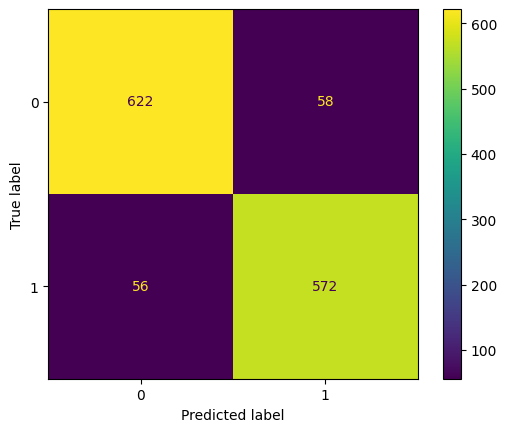

In [15]:
tn, fp, fn, tp = display_report(y_train, in_sample_preds)

In [16]:
fpr_max = fp / (tn + fp)
if fpr_max:
    fpr_max = min(fpr_max, 0.05)
else:
    fpr_max = 1e-4
print(fpr_max)

0.05


In [17]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(
    pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=fpr_max
)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.54


In [18]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [19]:
pipe.score(X_test, y_test)

0.58

              precision    recall  f1-score   support

           0       0.54      0.74      0.63        96
           1       0.64      0.42      0.51       104

    accuracy                           0.57       200
   macro avg       0.59      0.58      0.57       200
weighted avg       0.59      0.57      0.56       200



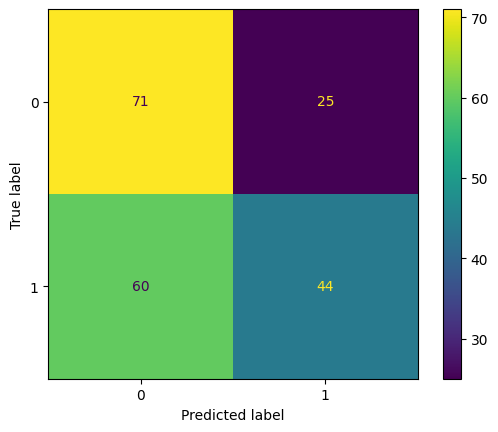

array([71, 25, 60, 44])

In [20]:
display_report(y_test, predictions)

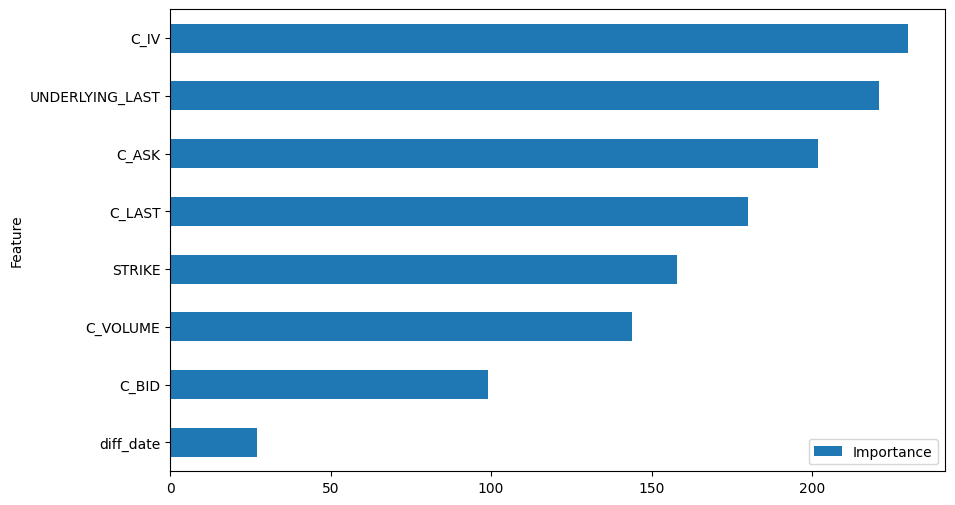

In [21]:
coefficients = pipe.named_steps["clf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [22]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_out"])

### Backtesting

In [23]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [24]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2023-03-16,0,396.0,7.15,2023-04-06,409.190002,0.000000,6.040002,0.000000,6.040002
2023-03-17,1,390.0,8.89,2023-04-06,409.190002,10.300002,10.300002,10.300002,16.340005
2023-03-20,0,394.0,7.65,2023-04-06,409.190002,0.000000,7.540002,10.300002,23.880007
2023-03-21,0,399.0,8.74,2023-04-14,412.459991,0.000000,4.719991,10.300002,28.599999
2023-03-22,0,392.0,11.25,2023-04-14,412.459991,0.000000,9.209991,10.300002,37.809990
...,...,...,...,...,...,...,...,...,...
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.000000,-3.020007,274.629913,492.519692
2023-12-26,0,476.0,6.12,2024-01-19,482.429993,0.000000,0.309993,274.629913,492.829685
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.000000,0.239993,274.629913,493.069678


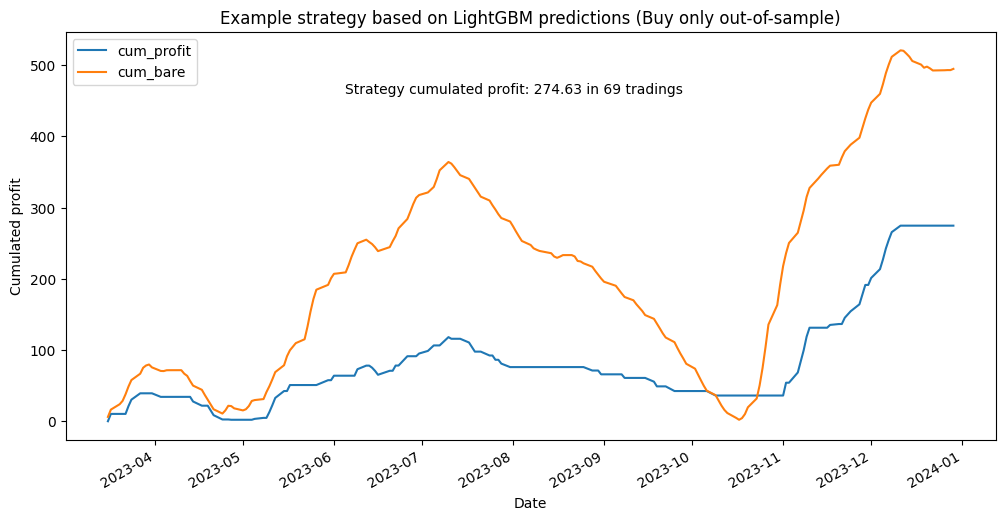

In [25]:
plot_strategy(strategy_df, "LightGBM", "(Buy only out-of-sample)")

In [26]:
compare_df["cum_profit_out"] = strategy_df["cum_profit"].values

## LightGBM with data from MC simulation and additional features

In [27]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike", "r"], axis=1),
    ),
    axis=1,
)

In [28]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### Split dataset

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df,
    target.values.flatten(),
    test_size=TEST_SIZE,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [30]:
params = tune_params(X_train, y_train, METRIC, TIMEOUT, max_iter=35, max_dep=12)

[I 2024-02-18 23:47:53,795] A new study created in memory with name: no-name-90cef67c-ea74-40e4-9aa1-7cf325ad10a3
[I 2024-02-18 23:47:54,056] Trial 0 finished with value: 0.5495520174483389 and parameters: {'n_estimators': 20, 'lambda_l1': 0.0026568795174116543, 'lambda_l2': 5.691357779832114, 'num_leaves': 51, 'min_sum_hessian_in_leaf': 3.06251108704905, 'feature_fraction': 0.700901728913941, 'feature_fraction_bynode': 0.40951542213203884, 'bagging_fraction': 0.4510358790928265, 'bagging_freq': 6, 'min_child_samples': 80, 'num_grad_quant_bins': 6, 'max_depth': 6, 'extra_trees': True}. Best is trial 0 with value: 0.5495520174483389.
[I 2024-02-18 23:47:54,325] Trial 1 finished with value: 0.5294220057469593 and parameters: {'n_estimators': 20, 'lambda_l1': 0.001149913335423407, 'lambda_l2': 17.663118301499786, 'num_leaves': 33, 'min_sum_hessian_in_leaf': 6.191357356715355, 'feature_fraction': 0.688325844495046, 'feature_fraction_bynode': 0.39313322880424395, 'bagging_fraction': 0.43045

[I 2024-02-18 23:47:55,148] Trial 2 finished with value: 0.6062679130705012 and parameters: {'n_estimators': 30, 'lambda_l1': 7.026512561223481, 'lambda_l2': 0.10460969069836508, 'num_leaves': 111, 'min_sum_hessian_in_leaf': 0.0686346071150847, 'feature_fraction': 0.9687323111073322, 'feature_fraction_bynode': 0.7886641910654983, 'bagging_fraction': 0.7993756724982497, 'bagging_freq': 2, 'min_child_samples': 35, 'num_grad_quant_bins': 10, 'max_depth': 5, 'extra_trees': False}. Best is trial 2 with value: 0.6062679130705012.
[I 2024-02-18 23:47:55,559] Trial 3 finished with value: 0.5826937419682825 and parameters: {'n_estimators': 35, 'lambda_l1': 13.213533808148366, 'lambda_l2': 1.016522600432179e-05, 'num_leaves': 215, 'min_sum_hessian_in_leaf': 5.0651583071521824e-05, 'feature_fraction': 0.9888487142893236, 'feature_fraction_bynode': 0.9441015572739095, 'bagging_fraction': 0.9682480562538636, 'bagging_freq': 2, 'min_child_samples': 14, 'num_grad_quant_bins': 12, 'max_depth': 2, 'ext

Number of finished trials: 150
Best trial:
  Number: 96
  Value: 0.7164096559390549
  Params: 
    n_estimators: 35
    lambda_l1: 0.0003280498150183608
    lambda_l2: 0.008412341146950665
    num_leaves: 86
    min_sum_hessian_in_leaf: 7.940967759048372e-05
    feature_fraction: 0.3757194989087465
    feature_fraction_bynode: 0.945902878059976
    bagging_fraction: 0.9315680452870049
    bagging_freq: 6
    min_child_samples: 21
    num_grad_quant_bins: 11
    max_depth: 12
    extra_trees: False


In [31]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "clf",
            lgb.LGBMClassifier(
                **params
                | {
                    "random_state": 1968,
                    "objective": "binary",
                    "metric": METRIC,
                    "verbosity": -1,
                    "boosting_type": "gbdt",
                }
            ),
        ),
    ]
)

In [32]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('clf',
                 LGBMClassifier(bagging_fraction=0.9315680452870049,
                                bagging_freq=6, extra_trees=False,
                                feature_fraction=0.3757194989087465,
                                feature_fraction_bynode=0.945902878059976,
                                lambda_l1=0.0003280498150183608,
                                lambda_l2=0.008412341146950665, max_depth=12,
                                metric='average_precision',
                                min_child_samples=21,
                                min_sum_hessian_in_leaf=7.940967759048372e-05,
                                n_estimators=35, num_grad_quant_bins=11,
                                num_leaves=86, objective='binary',
                                random_state=1968, verbosity=-1))])

In [33]:
# In-sample score
pipe.score(X_train, y_train)

0.9472477064220184

In [34]:
in_sample_preds = pipe.predict(X_train)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       680
           1       0.95      0.94      0.94       628

    accuracy                           0.95      1308
   macro avg       0.95      0.95      0.95      1308
weighted avg       0.95      0.95      0.95      1308



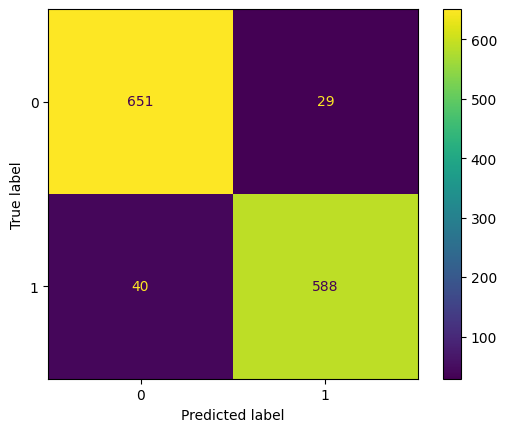

In [35]:
tn, fp, fn, tp = display_report(y_train, in_sample_preds)

In [36]:
fpr_max = fp / (tn + fp)
if fpr_max:
    fpr_max = min(fpr_max, 0.05)
else:
    fpr_max = 1e-4
print(fpr_max)

0.04264705882352941


In [37]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(
    pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=fpr_max
)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.50


In [38]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [39]:
pipe.score(X_test, y_test)

0.56

              precision    recall  f1-score   support

           0       0.54      0.58      0.56        96
           1       0.58      0.54      0.56       104

    accuracy                           0.56       200
   macro avg       0.56      0.56      0.56       200
weighted avg       0.56      0.56      0.56       200



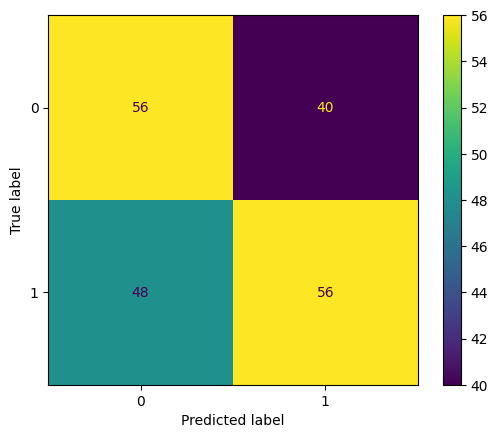

array([56, 40, 48, 56])

In [40]:
display_report(y_test, predictions)

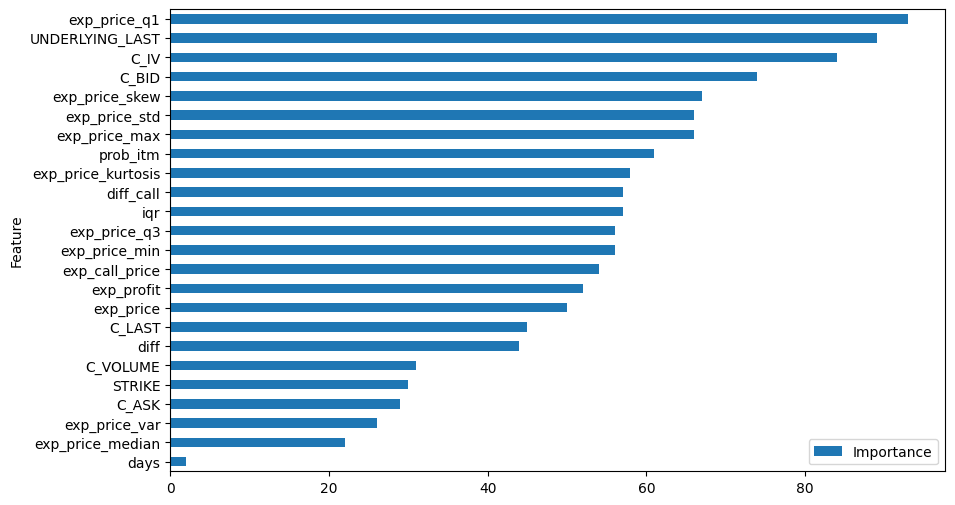

In [41]:
coefficients = pipe.named_steps["clf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [42]:
compare_df["mmar_rf_pred_out"] = predictions

### Backtesting

In [43]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [44]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2023-03-16,0,396.0,7.15,2023-04-06,409.190002,0.000000,6.040002,0.000000,6.040002
2023-03-17,1,390.0,8.89,2023-04-06,409.190002,10.300002,10.300002,10.300002,16.340005
2023-03-20,1,394.0,7.65,2023-04-06,409.190002,7.540002,7.540002,17.840005,23.880007
2023-03-21,0,399.0,8.74,2023-04-14,412.459991,0.000000,4.719991,17.840005,28.599999
2023-03-22,1,392.0,11.25,2023-04-14,412.459991,9.209991,9.209991,27.049996,37.809990
...,...,...,...,...,...,...,...,...,...
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.000000,-3.020007,322.379884,492.519692
2023-12-26,0,476.0,6.12,2024-01-19,482.429993,0.000000,0.309993,322.379884,492.829685
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.000000,0.239993,322.379884,493.069678


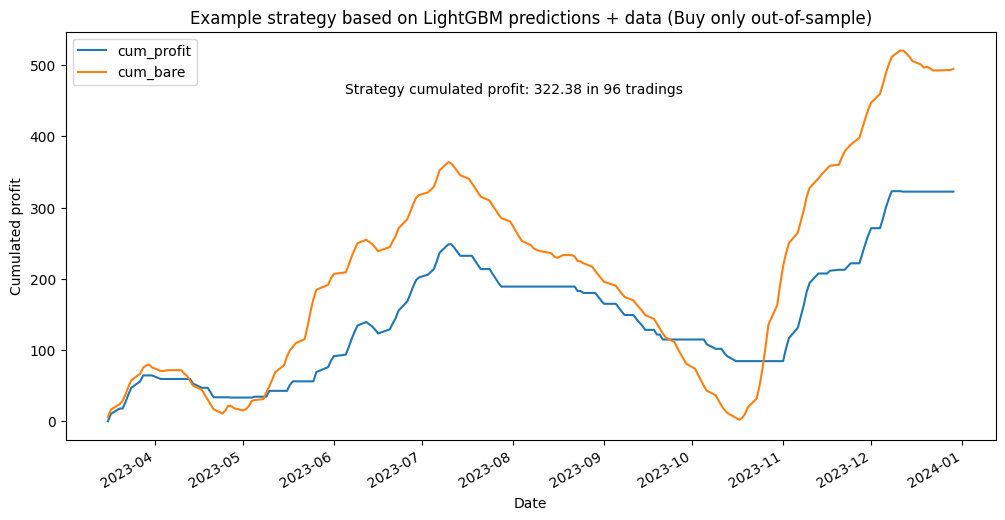

In [45]:
plot_strategy(strategy_df, "LightGBM", "+ data (Buy only out-of-sample)")

In [46]:
compare_df["mmar_cum_profit_out"] = strategy_df["cum_profit"].values
compare_df["mmar_cum_bare_out"] = strategy_df["cum_bare"].values

## Compare the two predictions

In [47]:
mask_out = (compare_df["bare_rf_pred_out"] - compare_df["mmar_rf_pred_out"]).astype(
    bool
)

In [48]:
# Compare out of sample preds
compare_df[mask_out]

,bare_rf_pred_out,cum_profit_out,mmar_rf_pred_out,mmar_cum_profit_out,mmar_cum_bare_out
2,0,10.300002,1,17.840005,23.880007
4,0,10.300002,1,27.049996,37.809990
8,0,39.219977,1,64.339983,75.099977
26,1,2.479987,0,33.639993,10.770011
36,1,4.719960,0,34.489977,31.119932
...,...,...,...,...,...
176,1,164.179950,0,221.749905,398.089751
179,0,191.379938,1,261.219886,437.559733
181,1,213.519926,0,271.039880,459.699720
186,1,274.629913,0,323.039871,520.809708


In [49]:
compare_df[mask_out].shape

(63, 5)

In [50]:
compare_df.sum(axis=0)

bare_rf_pred_out          69.000000
cum_profit_out         16485.814136
mmar_rf_pred_out          96.000000
mmar_cum_profit_out    29049.224025
mmar_cum_bare_out      41758.960105
dtype: float64

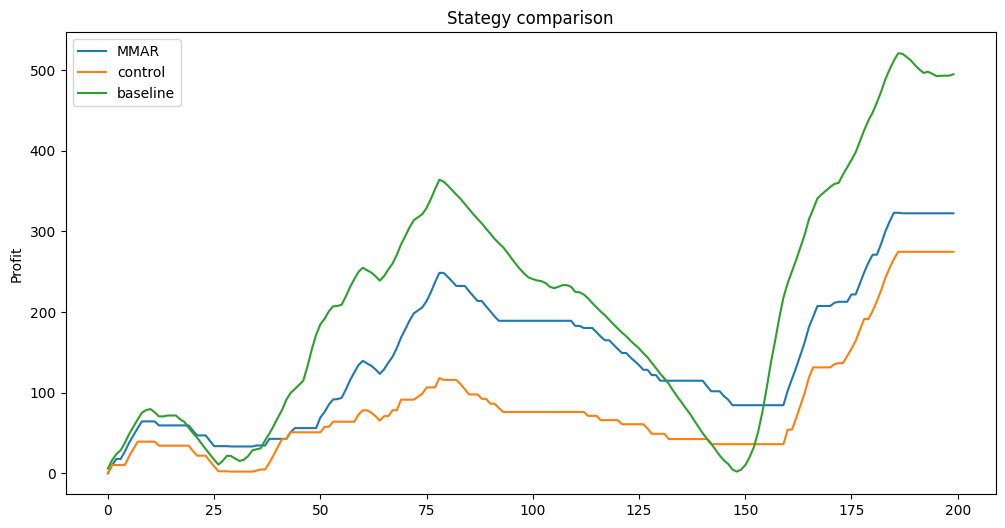

In [51]:
compare_df[["mmar_cum_profit_out", "cum_profit_out", "mmar_cum_bare_out"]].rename(
    {
        "mmar_cum_profit_out": "MMAR",
        "cum_profit_out": "control",
        "mmar_cum_bare_out": "baseline",
    },
    axis=1,
).plot(figsize=(12, 6), title="Stategy comparison", ylabel="Profit")
plt.show()